In [1]:
from collections import deque
from itertools import cycle
import numpy as np
from matplotlib import pyplot as plt
import torch

In [2]:
from environment import TicTacToeEnv
from agent import Agent

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
env = TicTacToeEnv()

In [5]:
X = Agent("X", state_size=env.size, action_size=env.size, device=device, seed=2022)
O = Agent("O", state_size=env.size, action_size=env.size, device=device, seed=2022)

In [6]:
"""Deep Q-Learning.

Params
======
    n_episodes (int): maximum number of training episodes
    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    eps_end (float): minimum value of epsilon
    eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
"""
n_episodes = 50000
eps_start = 1.0
eps_end = 0.01
eps_decay = 1 / n_episodes

In [7]:
# withdraw should reward both...
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon
counts = {"win": 0, "mistake": 0, "withdraw": 0}
outcomes = {X: counts.copy(), O: counts.copy()}
mistakes = []
mistake = 0
for i_episode in range(1, n_episodes + 1):
    state = env.reset()
    it = cycle([X, O])
    score = {X: 0, O: 0}
    while True:
        agent = next(it)
        action = agent.act(state, eps)
        next_state, reward, done, info = env.step(state, action, agent)
        agent.step(state, action, reward, next_state, done)
        state = next_state * -1 # needed to adapt to the next player's perspective
        score[agent] += reward
        if done:
            if info["outcome"] == "mistake":
                mistake += 1

            outcomes[agent][info["outcome"]] += 1
            break 
    eps = max(eps_end, eps - eps_decay)  # decrease epsilon

    max_score = max(score.values())
    scores_window.append(max_score)   
    avg_score_window = np.mean(scores_window)    
    scores.append(avg_score_window)
    print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.5f}'.format(i_episode, avg_score_window, eps), end="")
    if i_episode % 1000 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score_window))
        mistakes.append(mistake)
        mistake = 0
    if avg_score_window >= 0.8:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, avg_score_window))
        break
torch.save(X.qnetwork_local.state_dict(), 'X.pth')
torch.save(O.qnetwork_local.state_dict(), 'O.pth')
print(outcomes)

Episode 1000	Average Score: 0.46	eps: 0.98000
Episode 2000	Average Score: 0.53	eps: 0.96000
Episode 3000	Average Score: 0.54	eps: 0.94000
Episode 4000	Average Score: 0.59	eps: 0.92000
Episode 5000	Average Score: 0.64	eps: 0.90000
Episode 6000	Average Score: 0.57	eps: 0.88000
Episode 7000	Average Score: 0.57	eps: 0.86000
Episode 8000	Average Score: 0.63	eps: 0.84000
Episode 9000	Average Score: 0.67	eps: 0.82000
Episode 10000	Average Score: 0.66	eps: 0.80000
Episode 11000	Average Score: 0.66	eps: 0.78000
Episode 12000	Average Score: 0.66	eps: 0.76000
Episode 13000	Average Score: 0.67	eps: 0.74000
Episode 14000	Average Score: 0.66	eps: 0.72000
Episode 15000	Average Score: 0.70	eps: 0.70000
Episode 16000	Average Score: 0.65	eps: 0.68000
Episode 17000	Average Score: 0.69	eps: 0.66000
Episode 18000	Average Score: 0.72	eps: 0.64000
Episode 19000	Average Score: 0.71	eps: 0.62000
Episode 20000	Average Score: 0.72	eps: 0.60000
Episode 21000	Average Score: 0.73	eps: 0.58000
Episode 22000	Average 

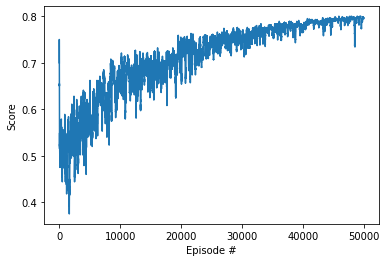

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

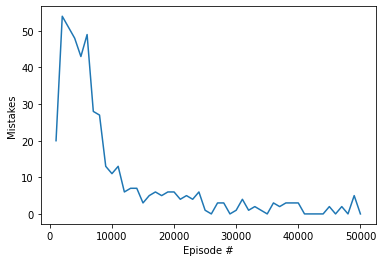

In [9]:
# plot the mistakes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(start = 1000, stop=(len(mistakes) + 1) * 1000, step=1000), mistakes)
plt.ylabel('Mistakes')
plt.xlabel('Episode #')
plt.show()

In [10]:
env.close()